In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
#%matplotlib notebook

## Read Data

In [3]:
#load data, drop the name, episodes, and members
## Read data
data_path = './data'
#anime = pd.read_csv(os.path.join(data_path,'anime_cleaned.csv')).drop(['anime_id', 'name','episodes','rating','members'], axis=1)#keep genre
anime = pd.read_csv(os.path.join(data_path,'anime_cleaned.csv')).drop(['anime_id', 'name'], axis=1) #keep genre


test_list = list(anime.columns)
test_string = 'type'
res = [ele for ele in test_list if(test_string in ele)]

print(res)

anime = anime.drop(res, axis=1)


rating = pd.read_csv(os.path.join(data_path,'rating_cleaned.csv'))
rating_derek = pd.read_csv(os.path.join(data_path,'rating_derek.csv'))
rating_fei = pd.read_csv(os.path.join(data_path,'rating_fei.csv'))
#read dataset with names
animeWithName = pd.read_csv(os.path.join(data_path, 'anime_cleaned.csv'))

['type_Movie', 'type_Music', 'type_ONA', 'type_OVA', 'type_Special', 'type_TV']


In [4]:
anime


,episodes,rating,members,genre_Drama,genre_Romance,genre_School,genre_Supernatural,genre_Action,genre_Adventure,genre_Fantasy,...,genre_Josei,genre_ShounenAi,genre_Game,genre_Dementia,genre_Harem,genre_Cars,genre_Kids,genre_ShoujoAi,genre_Yaoi,genre_Yuri
0,0.000000,4.621849,0.197867,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.034673,4.555822,0.782769,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.027518,4.549820,0.112683,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.012658,4.501801,0.664323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.027518,4.495798,0.149180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10251,0.000000,2.430972,0.004901,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10252,0.001101,2.406963,0.005163,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
10253,0.000000,2.172869,0.003316,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10254,0.000550,2.136855,0.004476,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Hyperparameters

In [5]:
n_clusters = 20
good_rating_threshold = 5

## Creat dataset

In [6]:
animeData = np.array(anime).astype(int)

(44, 44)


Text(0, 0.5, 'Eigenvalue')

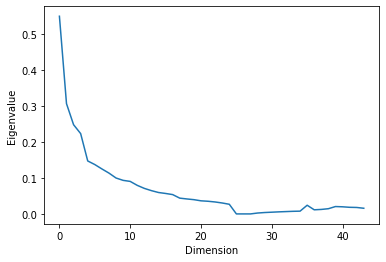

In [7]:
## Visualize PCA-explained variance ratio
animeData_cov = np.cov(np.transpose(animeData))
print(animeData_cov.shape)
eigenvalues, eigenvectors = np.linalg.eig(animeData_cov)
plt.plot(eigenvalues)
plt.xlabel('Dimension')
plt.ylabel('Eigenvalue')

## PCA 
### Reduce to 3-dimension

In [8]:
pca = PCA(n_components = 3)
pca.fit(animeData[:,1:len(animeData)-4])
pca_samples = pca.transform(animeData[:,1:len(animeData)-4])
print(pca_samples)
tocluster = pd.DataFrame(pca_samples)
tocluster

[[-1.62782022 -0.42699512 -1.23559842]
 [-1.97614338  0.80523615  0.17405155]
 [-1.81715405  0.1194199   0.56354707]
 ...
 [ 0.22529795  0.93815477 -0.00754106]
 [ 0.33642655 -0.01040943 -0.87830075]
 [ 0.55708072  0.0372788  -0.30918421]]


,0,1,2
0,-1.627820,-0.426995,-1.235598
1,-1.976143,0.805236,0.174052
2,-1.817154,0.119420,0.563547
3,-1.391923,0.155793,-0.512500
4,-1.817154,0.119420,0.563547
...,...,...,...
10251,0.385107,-0.211348,-1.165065
10252,0.263360,0.987988,-0.003108
10253,0.225298,0.938155,-0.007541
10254,0.336427,-0.010409,-0.878301


In [9]:
print('PCA explained variance ratio: ', sum(pca.explained_variance_ratio_))

PCA explained variance ratio:  0.36772646983782065


## K-means or EM

In [10]:
## K-means
clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

## EM
#clusterer = GaussianMixture(n_components=n_clusters, random_state=None).fit(tocluster)
#centers = clusterer.means_
#c_preds = clusterer.predict(tocluster)


for i in centers:
 print(i)

plt.rcParams['figure.figsize'] = (9, 7)



[-0.64440112  0.30724023  0.09918621]
[0.48896362 0.18221009 0.04518679]
[-0.54710045 -0.15434994 -0.94869886]
[ 0.53394843 -0.0017808  -0.49018726]
[-0.57286462 -0.92549071 -0.15205893]
[ 1.55973542  0.18524542 -0.19287345]
[0.1623136  1.03437914 0.39348513]
[-0.95180907  0.21322991  1.04116542]
[-0.8461473   0.87738125  0.39319441]
[ 1.44212735 -0.40800901  0.47656306]
[-0.5416145  -0.68259854  0.20510641]
[ 0.45216274 -0.6033467   0.27140569]
[-1.54798081 -0.29028752 -0.48132398]
[-0.71077567 -0.25812049  0.64339635]
[ 0.32312831  0.62111213 -0.11528912]
[-0.42524045 -0.11576442 -0.43534894]
[-0.64834005  0.4296862  -0.43380825]
[ 0.26602229 -0.05814478  0.79237472]
[1.23807348 0.90756762 0.36712933]
[-0.80454532  0.94060512 -0.23902219]


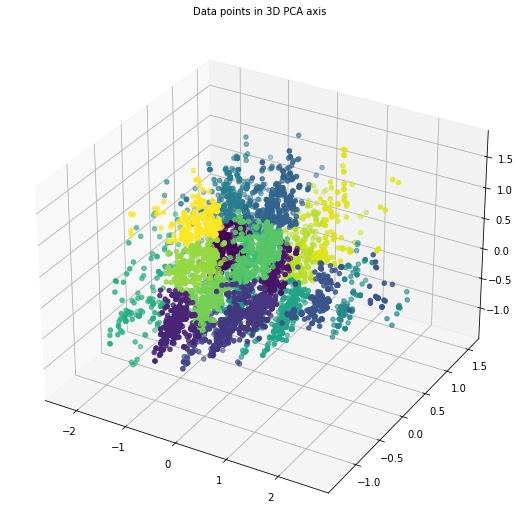

In [11]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=10)
plt.show()

 ## Regenerate Centers with Anime Names

In [12]:
#assign each anime with its cluster
animeWithName['cluster centers'] = c_preds
animeWithName['pca_x'] = tocluster[0]
animeWithName['pca_y'] = tocluster[1]
animeWithName['pca_z'] = tocluster[2]

In [13]:
#define function to view a cluster dedicatly
def clusterView(df):
    colNames = [column for column in df]
    #only read the genre of animes
    genreNames = colNames[5:len(colNames) - 8]#only count genre
    genreDict = {}
    nameDict = {}
    #create empty dict for cols
    for i in genreNames:
        genreDict [i] = 0
    for i in genreNames:
        genreScore = np.sum(df[i])
        genreDict [i] = genreScore
    #sort the map
    genreSort = sorted(genreDict.items(), key = lambda kv:(kv[1], kv[0]))
    print("liked genres and appeared time:")
    for i in reversed(genreSort):
        print(i)    
    
    return reversed(genreSort)       

In [14]:
def pickTopAnime(df):
    #get the center
    center = df['cluster centers']
    clusterCenter = centers[center - 1]
    #choose the nearest datapoint
    pcaPoints = df[['pca_x','pca_y','pca_z']]
    
    distances = [] 
    
    center = np.array(clusterCenter)
    pcas = np.array(pcaPoints)
   
    distances = np.sum(np.square(center-pcas),1) 
    listDistances = distances.tolist()
    
    topAnime = {}
    
    for i in range(len(listDistances)):
        topAnime[df.iloc[i,1]] = (listDistances[i])
      
     
    animeSort =  sorted(topAnime.items(), key = lambda kv:(kv[1], kv[0]))
    #print( animeSort)
    return animeSort
    

In [15]:
 def getMean(userid, rating, anime):
    user = rating.loc[rating['user_id']==userid]
    mean = np.mean(user['rating'])
    
    animeLike = np.array(user.loc[user['rating'] > mean]['anime_id'])
    #animeLike = np.array(user.loc[user['rating'] > good_rating_threshold]['anime_id'])
    
    x = 0.0
    y = 0.0
    z = 0.0
    count = 0
    print(animeLike)
    for i in animeLike:
        try:
            temp = anime.loc[anime['anime_id'] == i]
            #print(count)
        except:
            continue
        count += 1
        x += float(temp['pca_x'])
        y += float(temp['pca_y'])
        z += float(temp['pca_z'])
    return [x/count,y/count,z/count]

In [16]:
def recommand(mean, centers):
    shortest = 10000.0
    idx = 0
    for c in range(len(centers)):
        distance = np.sqrt(np.sum((centers[c] - mean)**2))
        if distance < shortest:
            shortest = distance
            idx = c
    return idx

 ## Recommendation system test out

In [17]:
#allocating clusters:
animeClusters = []
genreScores = []
topAnimes = []
for i in range(n_clusters):
    animeClusters.append(animeWithName.loc[animeWithName['cluster centers']==i])

#usermean = getMean(11, rating, animeWithName)
usermean_derek = getMean(-2, rating_derek, animeWithName)
#usermean_fei = getMean(-6, rating_fei, animeWithName)

usermean = usermean_derek

print("the user mean are: ", usermean)
index = recommand(usermean, centers)
print("choosing clustering #", index)

[11741 10087  5114  9253  4224  2670]
the user mean are:  [-1.45142403994212, 0.0007585363136606849, 0.02660943012915355]
choosing clustering # 12


In [18]:
print(clusterView(animeClusters[index]))

liked genres and appeared time:
('genre_Drama', 91.0)
('genre_Comedy', 62.0)
('genre_Supernatural', 54.0)
('type_Movie', 42)
('genre_Romance', 42.0)
('genre_Fantasy', 41.0)
('genre_Shounen', 40.0)
('genre_SliceofLife', 38.0)
('genre_Historical', 37.0)
('genre_Action', 34.0)
('genre_School', 29.0)
('genre_Mystery', 29.0)
('genre_Adventure', 29.0)
('genre_Sports', 27.0)
('genre_Seinen', 21.0)
('genre_Kids', 19.0)
('genre_Sci-Fi', 18.0)
('genre_Psychological', 17.0)
('genre_Thriller', 15.0)
('genre_Shoujo', 12.0)
('genre_Music', 7.0)
('genre_Magic', 7.0)
('genre_Josei', 7.0)
('genre_Horror', 6.0)
('genre_Demons', 6.0)
('genre_Vampire', 5.0)
('genre_Military', 5.0)
('genre_SuperPower', 4.0)
('genre_Space', 4.0)
('genre_Police', 4.0)
('genre_Parody', 4.0)
('genre_Samurai', 3.0)
('genre_MartialArts', 3.0)
('type_Music', 1)
('genre_ShounenAi', 1.0)
('genre_Mecha', 1.0)
('genre_Harem', 1.0)
('genre_Game', 1.0)
('genre_Dementia', 1.0)
('genre_Yuri', 0.0)
('genre_Yaoi', 0.0)
('genre_ShoujoAi', 0

In [19]:
rec_list = pickTopAnime(animeClusters[index])
print("top pick for the user is: ", rec_list[0][0])

top pick for the user is:  Santa-san wa Dai Isogashi


In [20]:
rec_list

[('Santa-san wa Dai Isogashi', 3.3393252149407173),
 ('Chamebou Kuukijuu no Maki', 3.4329537503978513),
 ('Gintama°: Aizome Kaori-hen', 3.4384389510058098),
 ('Fushigi no Yappo Shima: Pukipuki to Poi', 3.449113854708627),
 ('Tsuru no Sugomori', 3.449113854708627),
 ('Yuri!!! on Ice', 3.518764360902291),
 ('Spoon-hime no Swing Kitchen', 3.572964713082406),
 ('Hato yo: Hiroshima no Sora wo', 3.7259525927765775),
 ('Kie Saranu Kizuato: Hi no Umi Osaka', 3.7259525927765775),
 ('Okaachan Gomen ne', 3.7259525927765775),
 ('Nodame Cantabile Finale', 3.8144957103193455),
 ('Owarimonogatari', 3.837562562399929),
 ('Ookami Kodomo no Ame to Yuki', 3.89026301237915),
 ('Kamisama Hajimemashita: Kako-hen', 3.940104399845893),
 ('Uchuu Kyoudai', 4.00586044188928),
 ('Hajime no Ippo: Champion Road', 4.006156157591024),
 ('Tonari no Totoro', 4.0112745167444785),
 ('Kaguya-hime no Monogatari', 4.051829032335197),
 ('Telemonster', 4.064084921026041),
 ('Mogura no Motoro', 4.081911628199925),
 ('Shisei Sa